# Experiments


In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import seaborn as sns
from models import *
from utils import *
from torch.utils.data import DataLoader

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Approximate BNN

In [4]:
# load data generated from approximate BNN
X_train, Y_train = load_data('./data/', 'abnn_ff_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_ff_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_ff_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [12]:
def param_grid_search(hidden_dims, n_layerss):
    final_eval_loss = np.zeros((len(hidden_dims), len(n_layerss)))

    for i, hidden_dim in enumerate(hidden_dims):
        for j, n_layers in enumerate(n_layerss):

            # deep learning model
            DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)

            # training parameters
            optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
            criterion = nn.MSELoss()    

            train_losses, eval_losses = train(
                model=DNN,
                train_loader=valid_dataloader, test_loader=test_dataloader,
                optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
                verbose=False, force_stop=False)

            print(f'{n_layers} layers, {hidden_dim} hidden units, final eval loss: {eval_losses[-1]}', end='\r')
            final_eval_loss[i,j] = eval_losses[-1]
    
    return final_eval_loss

def repeated_param_grid_search(hidden_dims, n_layerss, n_repeats):
    
    final_eval_loss_matrix = np.zeros((len(hidden_dims), len(n_layerss)))
    start = time.time()
    
    for i in range(n_repeats):
        
        final_eval_loss = param_grid_search(hidden_dims, n_layerss)
        final_eval_loss_matrix += final_eval_loss
        
        repeat_end = time.time()
        _, elapsed_m, elapsed_s = elapsed_time(start, repeat_end)
        
        r, c = find_argmin_in_matrix(final_eval_loss)
        print(f'{i+1}th repeat: best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}, final eval loss: {final_eval_loss[r,c]}, time elapsed: {elapsed_m} m {elapsed_s} s')
    
    return final_eval_loss_matrix / n_repeats

In [13]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=50)

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 2.91230309009552, time elapsed: 2 m 52 s


KeyboardInterrupt: 

Best hidden unit: 64, best layers: 1


/tmp/ipykernel_6864/4098690076.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(plt3d)


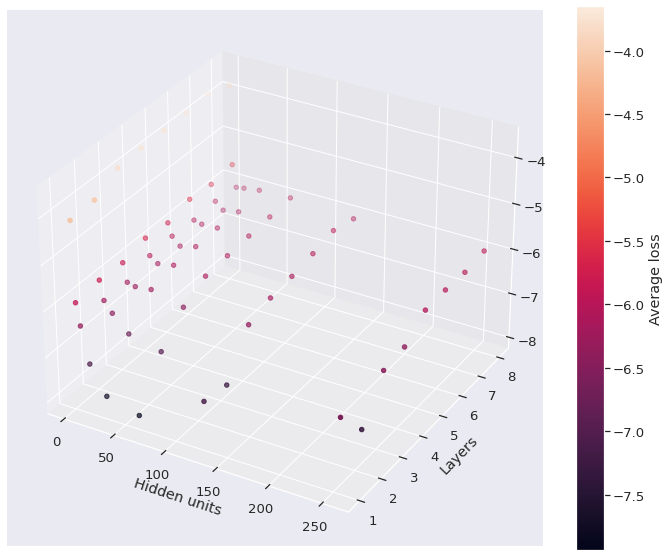

In [19]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_log_ff')

###  2. Learning with best parameter

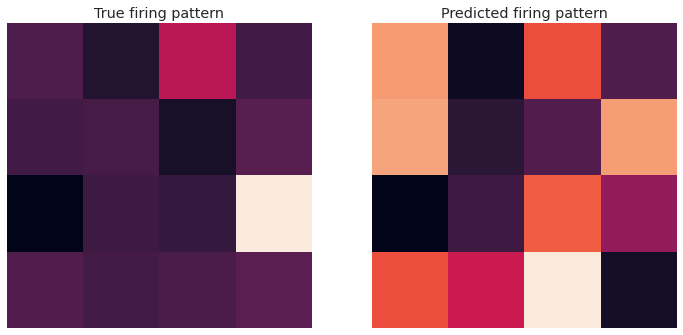

Initial eval loss: 4.689748108386993
Epoch 1: training loss 36.72286620736122, eval loss 3.0899531841278076. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 28.938034653663635, eval loss 2.6859026849269867. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 25.541313111782074, eval loss 2.483394354581833. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 23.4486623108387, eval loss 2.2198676466941833. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 21.52196727693081, eval loss 2.0734458565711975. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 19.972083792090416, eval loss 1.9459563195705414. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 18.57065086066723, eval loss 1.862803876399994. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 17.35769359767437, eval loss 1.7758698463439941. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 16.353597924113274, eval loss 1.7467734813690186. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 15.601332440972328, eval loss 1.726984769105911

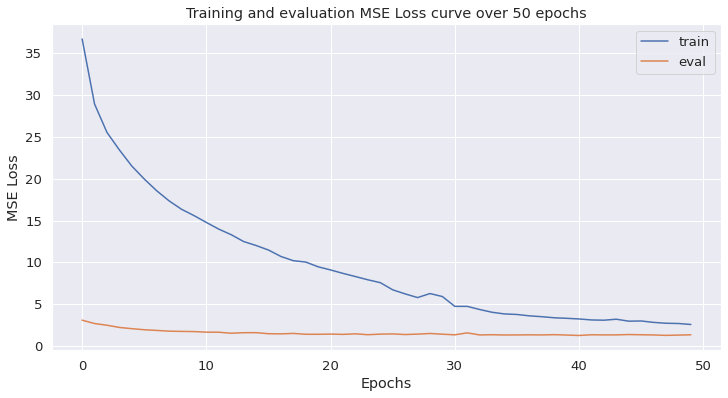

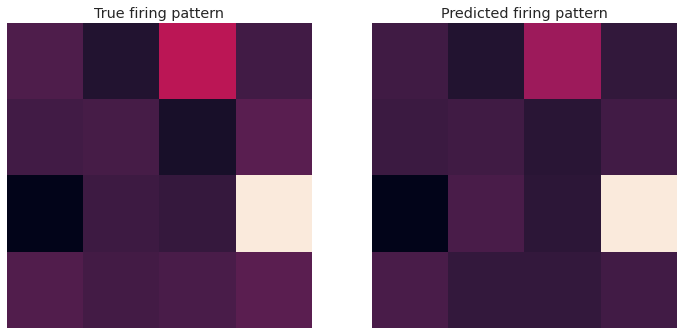

In [5]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_train[13,:], DNN(X_train[13,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_train[13,:], DNN(X_train[13,:])) # visualise after training

### 3. Testing against predicting the mean

In [6]:
actual_mean = torch.mean(Y_train, dim=0)

In [8]:
import torch.nn.functional as F

In [9]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
F.mse_loss(DNN(X_test), Y_test)

tensor(0.2683, device='cuda:0', grad_fn=<MseLossBackward0>)

In [10]:
F.mse_loss(torch.mean(Y_test, dim=0), Y_test)

/tmp/ipykernel_39169/1732143780.py:1: UserWarning: Using a target size (torch.Size([1000, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(torch.mean(Y_test, dim=0), Y_test)


tensor(0.9366, device='cuda:0')

In [12]:
def sample_location(length, width):
    return (np.random.uniform(0, length), np.random.uniform(0, width))

def compute_dist_to_borders

(1.4259106410464544, 1.285412778560477)